In [1]:
from NN.model_for_mnist import *
import numpy as np
from sklearn.model_selection import train_test_split
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

batch_size=16

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device = "cpu"

In [2]:
from get import load_datasets, display_dataset

X_labeled, y_labeled, X_unlabeled, X_val = load_datasets(888)

{0: '00_toy_dataset', 1: '01_mnist_cc', 2: '02_mnist_constant_image', 3: '03_mnist_constant_image_random_row', 4: '04_mnist_uniform_color_random_row', 5: '05_mnist_uniform_color_low_mix_rate', 6: '06_mnist_sum', 7: '07_mnist_sum_bis', 8: '08_mnist_sum_noise_level', 12: '12_mnist_mysterious', 13: '13_mnist_mysterious', 23: '23_mnist_embed', 456: '456_mnist_embed', 888: '888_vehicle_animal', 998: '998_zip_humans', 999: '999_humans'}


In [3]:
print("Labeled ds shape: ", X_labeled.shape)
print("Unlabeled ds shape: ", X_unlabeled.shape)
print("Validation ds shape: ", X_val.shape)
print("Labels shape: ", y_labeled.shape)
print("Labeled ds labels: ", np.unique(y_labeled))

Labeled ds shape:  torch.Size([10000, 3, 32, 64])
Unlabeled ds shape:  torch.Size([20000, 3, 32, 64])
Validation ds shape:  torch.Size([20000, 3, 32, 64])
Labels shape:  torch.Size([10000])
Labeled ds labels:  [0. 1.]


In [4]:
# CUt 10000, 3, 32, 64 shaped images to 20000, 3, 32, 32
X_labeled_left = X_labeled[:, :, :, :32]
X_labeled_right = X_labeled[:, :, :, 32:]
y_labeled_left = y_labeled
y_labeled_right = y_labeled

X_unlabeled_left = X_unlabeled[:, :, :, :32]
X_unlabeled_right = X_unlabeled[:, :, :, 32:]

X_val_left = X_val[:, :, :, :32]
X_val_right = X_val[:, :, :, 32:]

In [5]:
# Concatenate left and right images
X_labeled_both = np.concatenate((X_labeled_left, X_labeled_right), axis=0)
y_labeled_both = np.concatenate((y_labeled_left, y_labeled_right), axis=0)
X_unlabeled_both = np.concatenate((X_unlabeled_left, X_unlabeled_right), axis=0)
X_val_both = np.concatenate((X_val_left, X_val_right), axis=0)

X_all_both = np.concatenate((X_labeled_both, X_unlabeled_both, X_val_both), axis=0)

In [6]:
# Print shapes
print("Labeled ds shape: ", X_labeled_both.shape)
print("Unlabeled ds shape: ", X_unlabeled_both.shape)
print("Validation ds shape: ", X_val_both.shape)
print("Labels shape: ", y_labeled_both.shape)
print("Labeled ds labels: ", np.unique(y_labeled_both))
print("All ds shape: ", X_all_both.shape)

Labeled ds shape:  (20000, 3, 32, 32)
Unlabeled ds shape:  (40000, 3, 32, 32)
Validation ds shape:  (40000, 3, 32, 32)
Labels shape:  (20000,)
Labeled ds labels:  [0. 1.]
All ds shape:  (100000, 3, 32, 32)


In [7]:
# Data loader
from torch.utils.data import DataLoader, TensorDataset
def get_data_loader(X, batch_size):
    tensor_x = torch.Tensor(X_all_both) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x) # create your datset
    return DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

train_loader = get_data_loader(X_all_both, batch_size)
val_loader = get_data_loader(X_val_both, batch_size)

print(train_loader.dataset.tensors[0].shape)


torch.Size([100000, 3, 32, 32])


In [8]:
# Define autoencoder
class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )

    def forward(self, x):
        return self.net(x)
    
    
class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

In [9]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoder = Encoder(num_input_channels=3, base_channel_size=64, latent_dim=16)
decoder = Decoder(num_input_channels=3, base_channel_size=64, latent_dim=16)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Decoder(
  (linear): Sequential(
    (0): Linear(in_features=16, out_features=2048, bias=True)
    (1): GELU(approximate='none')
  )
  (net): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): GELU(approximate='none')
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU(approximate='none')
    (8): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (9): Tanh()
  )
)

In [10]:

### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch[0].to(device)    
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


In [11]:
### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch[0].to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


In [12]:

def plot_ae_outputs_den(encoder,decoder,n=10,noise_factor=0.3):
    plt.figure(figsize=(16,4.5))
    # targets = X_val_both
    # t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}    
    for i in range(n):

      ax = plt.subplot(3,n,i+1)
      img = X_val_both[i]
      image_noisy = X_val_both(img,0)     
      image_noisy = image_noisy.to(device)

      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(image_noisy))

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   


In [13]:

### Training cycle
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    ### Validation  (use the testing function)
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=val_loader, 
        loss_fn=loss_fn)
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    
    print('\r EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss), end = '\r')
    torch.save(encoder.state_dict(), "models/encoder_vehicle.pth")
    torch.save(decoder.state_dict(), "models/decoder_vehicle.pth")


EPOCH 1/30
	 partial train loss (single batch): 0.249515
	 partial train loss (single batch): 0.258906
	 partial train loss (single batch): 0.284434
	 partial train loss (single batch): 0.319604
	 partial train loss (single batch): 0.258036
	 partial train loss (single batch): 0.240569
	 partial train loss (single batch): 0.220776
	 partial train loss (single batch): 0.331720
	 partial train loss (single batch): 0.301626
	 partial train loss (single batch): 0.296437
	 partial train loss (single batch): 0.251731
	 partial train loss (single batch): 0.263498
	 partial train loss (single batch): 0.274123
	 partial train loss (single batch): 0.271177
	 partial train loss (single batch): 0.242183
	 partial train loss (single batch): 0.252687
	 partial train loss (single batch): 0.230477
	 partial train loss (single batch): 0.304265
	 partial train loss (single batch): 0.232862
	 partial train loss (single batch): 0.260593
	 partial train loss (single batch): 0.177916
	 partial train loss (s

: 

: 

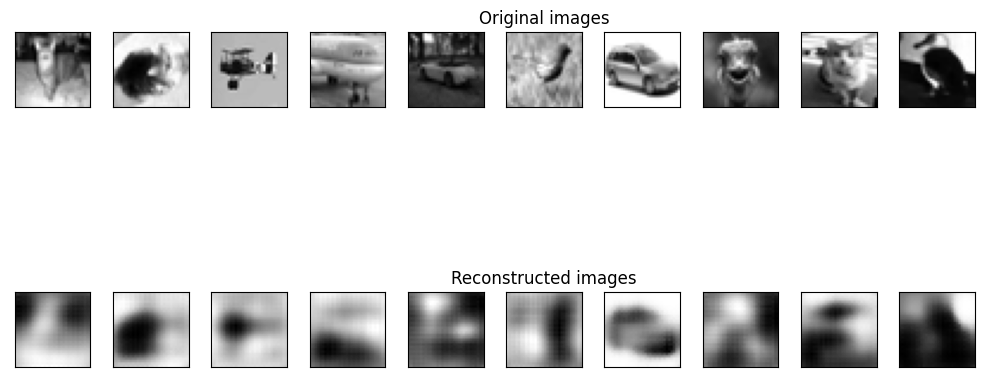

In [ ]:
def plot_ae_outputs_den(encoder,decoder,n=10,noise_factor=0.3):
    plt.figure(figsize=(16,4.5))
    # targets = X_val_both
    # t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}  
    images = torch.from_numpy(X_val_both).float()[:10]
    with torch.no_grad():
      images_recovered  = decoder(encoder(images))
         
    for i in range(n):

      ax = plt.subplot(3,n,i+1)

      encoder.eval()
      decoder.eval()
      
      img = images[i, 0]
      img_recov = images_recovered[i, 0]

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(img_recov.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show() 
    
plot_ae_outputs_den(encoder,decoder)

In [ ]:
torch.save(encoder.state_dict(), "models/encoder_vehicle.pth")
torch.save(decoder.state_dict(), "models/decoder_vehicle.pth")


In [ ]:
encoder = Encoder(num_input_channels=3, base_channel_size=64, latent_dim=16)
encoder.load_state_dict(torch.load("models/encoder_vehicle.pth"))
encoder

Encoder(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU(approximate='none')
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU(approximate='none')
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU(approximate='none')
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=2048, out_features=16, bias=True)
  )
)